# RL 训练分析与收敛性判断
本 Notebook 用于加载 `checkpoints/training_status.json` 中的数据，可视化 Loss 变化，并对模型的收敛性进行分析。

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# 配置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.sans-serif'] = ['DejaVu Sans'] # 确保支持负号和中文显示


In [2]:
def load_training_data(file_path="checkpoints/training_status.json"):
    if not Path(file_path).exists():
        print(f"Error: {file_path} not found!")
        return None
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # 转换为 DataFrame
    df_main = pd.DataFrame({
        'Loss': data.get('loss_history_main', []),
        'Reward': data.get('reward_history_main', [])
    })
    df_little = pd.DataFrame({
        'Loss': data.get('loss_history_little', []),
        'Reward': data.get('reward_history_little', [])
    })
    df_tps = pd.DataFrame({'TPS': data.get('tps_history', [])})
    
    return df_main, df_little, df_tps, data.get('last_update', 'N/A')

df_main, df_little, df_tps, last_update = load_training_data()
print(f"数据加载成功！上次更新时间: {last_update}")
print(f"Main Agent 记录条数: {len(df_main)}")
print(f"Little Agent 记录条数: {len(df_little)}")
print(f"TPS 记录条数: {len(df_tps)}")


数据加载成功！上次更新时间: 2026-01-26 22:22:05
Main Agent 记录条数: 5822
Little Agent 记录条数: 5822
TPS 记录条数: 2000


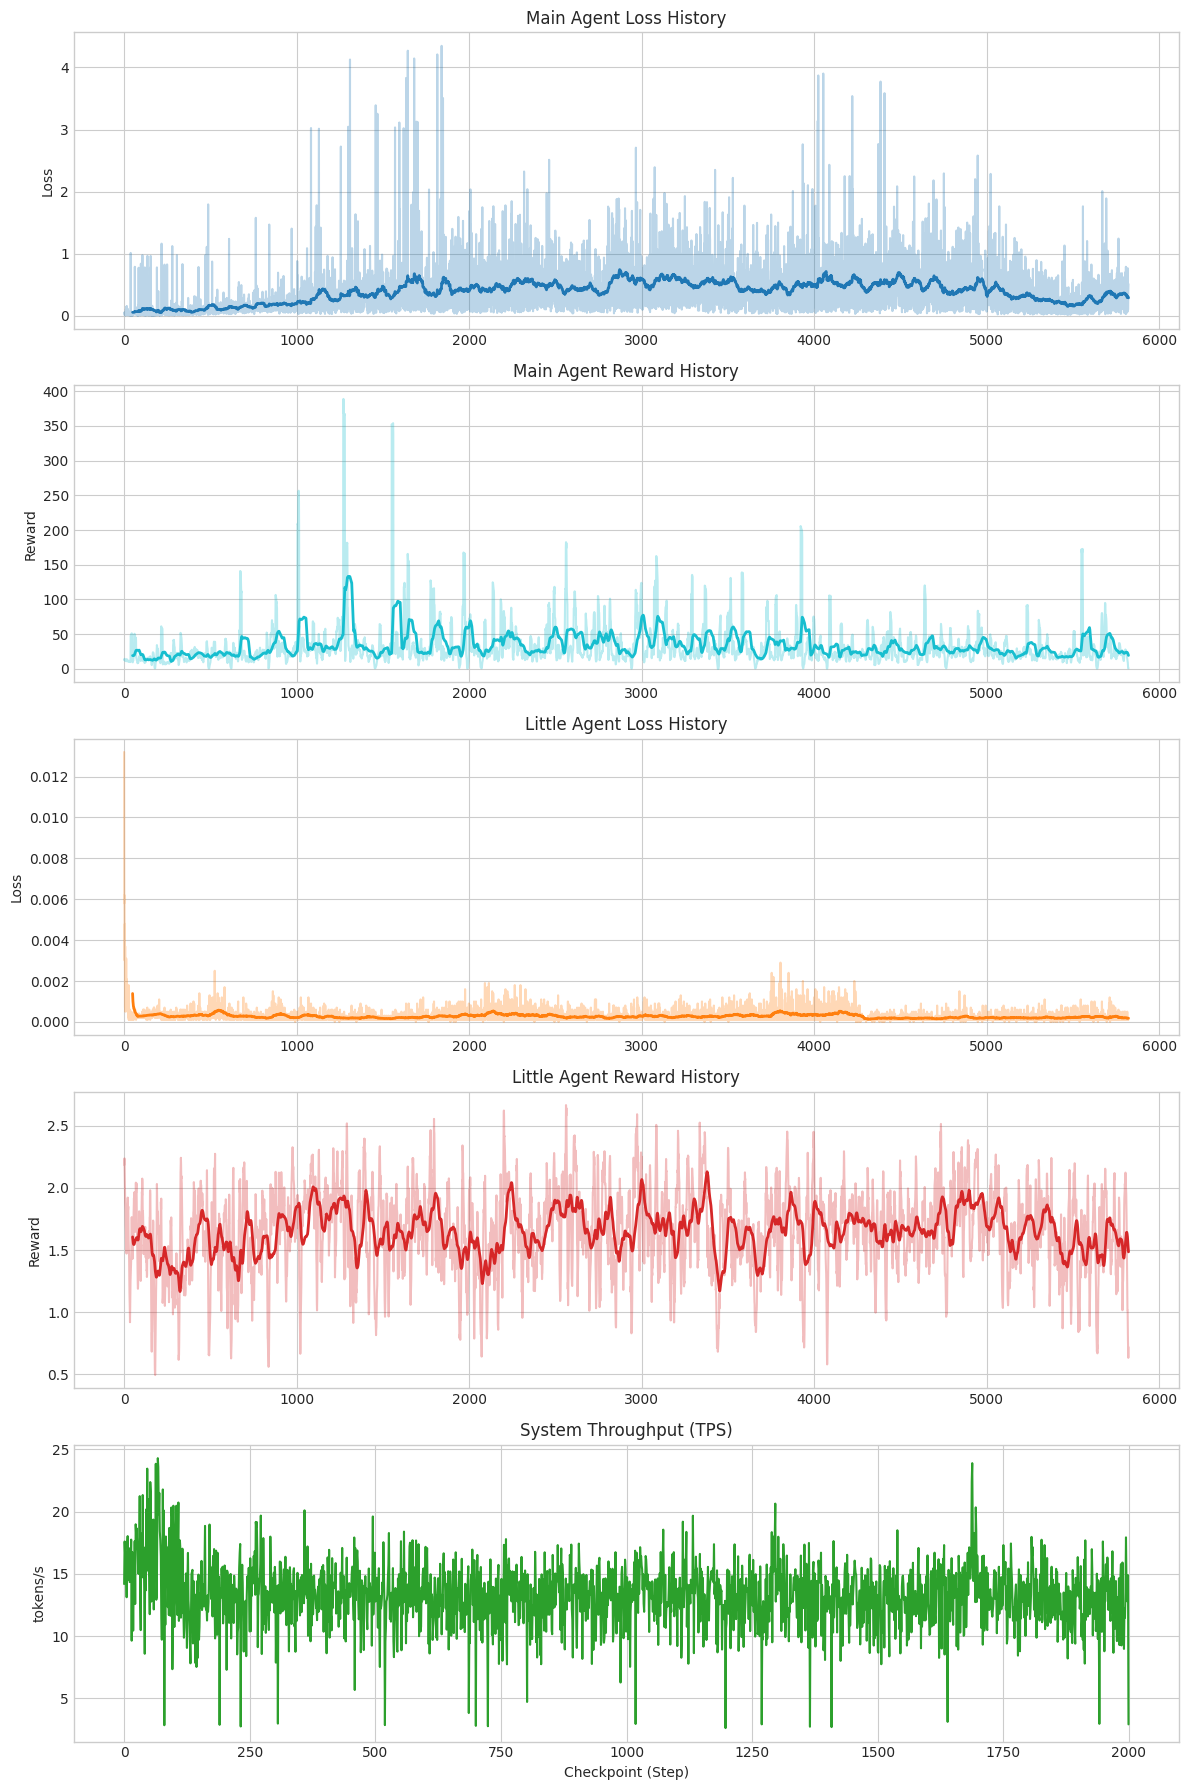

In [3]:
def plot_metrics(df_main, df_little, df_tps):
    fig, axes = plt.subplots(5, 1, figsize=(12, 18), sharex=False)
    
    # --- Main Agent ---
    # Loss
    axes[0].plot(df_main['Loss'], color='tab:blue', alpha=0.3)
    if len(df_main) > 50:
        axes[0].plot(df_main['Loss'].rolling(window=50).mean(), color='tab:blue', linewidth=2, label='SMA 50')
    axes[0].set_title('Main Agent Loss History')
    axes[0].set_ylabel('Loss')
    
    # Reward
    axes[1].plot(df_main['Reward'], color='tab:cyan', alpha=0.3)
    if len(df_main) > 50:
        axes[1].plot(df_main['Reward'].rolling(window=50).mean(), color='tab:cyan', linewidth=2, label='SMA 50')
    axes[1].set_title('Main Agent Reward History')
    axes[1].set_ylabel('Reward')

    # --- Little Agent ---
    # Loss
    axes[2].plot(df_little['Loss'], color='tab:orange', alpha=0.3)
    if len(df_little) > 50:
        axes[2].plot(df_little['Loss'].rolling(window=50).mean(), color='tab:orange', linewidth=2, label='SMA 50')
    axes[2].set_title('Little Agent Loss History')
    axes[2].set_ylabel('Loss')

    # Reward
    axes[3].plot(df_little['Reward'], color='tab:red', alpha=0.3)
    if len(df_little) > 50:
        axes[3].plot(df_little['Reward'].rolling(window=50).mean(), color='tab:red', linewidth=2, label='SMA 50')
    axes[3].set_title('Little Agent Reward History')
    axes[3].set_ylabel('Reward')
    
    # --- System TPS ---
    axes[4].plot(df_tps['TPS'], color='tab:green', linewidth=1.5)
    axes[4].set_title('System Throughput (TPS)')
    axes[4].set_ylabel('tokens/s')
    axes[4].set_xlabel('Checkpoint (Step)')
    
    plt.tight_layout()
    plt.show()

if df_main is not None:
    plot_metrics(df_main, df_little, df_tps)


In [4]:
def check_convergence(df, name="Agent", window=100):
    if len(df) < window * 2:
        return f"{name}: 数据量不足，无法判断收敛性。"
    
    recent_loss = df['Loss'].tail(window)
    prev_loss = df['Loss'].iloc[-window*2 : -window]
    
    avg_recent = recent_loss.mean()
    avg_prev = prev_loss.mean()
    
    # 计算斜率 (近似)
    slope = (avg_recent - avg_prev) / window
    # 计算波动率 (标准差)
    volatility = recent_loss.std()
    
    status = "收敛中"
    if abs(slope) < 1e-5 and volatility < 0.02:
        status = "已稳定收敛"
    elif slope > 0:
        status = "Loss 反弹 (可能过拟合或学习率过大)"
    else:
        status = "仍在下降"
        
    return {
        "Agent": name,
        "Status": status,
        "Avg Loss": round(avg_recent, 6),
        "Slope": f"{slope:.2e}",
        "Volatility": round(volatility, 4)
    }

if df_main is not None:
    results = [
        check_convergence(df_main, "Main Agent"),
        check_convergence(df_little, "Little Agent")
    ]
    display(pd.DataFrame(results))


,Agent,Status,Avg Loss,Slope,Volatility
0,Main Agent,Loss 反弹 (可能过拟合或学习率过大),0.325141,8.35e-06,0.2429
1,Little Agent,已稳定收敛,0.000196,-6.00e-07,0.0002
